# 📊🧪 Literature Screening – Multi‑class Model Evaluation
Aggregate results for **train** and **test** splits, report core metrics for the binary *Included vs Excluded* task, then evaluate the extra fields returned *only* for items predicted as **Included**.

We focus on the structured fields that are straightforward to score:
* **domain** → matches column **Social, Behavioural or Implementation Science?**
* **dmf_stage** → matches column **DMF - Identify the issue and its context, assess risks and benefits, identify and analyze options, select a strategy, implement the strategy, monitor and evaluate results, involve interested and affected parties**
* **decision_type** → matches column **DMF - Are the decisions regulatory, policy, or other? Please describe the “other” if applicable.**  
  For **decision_type** a prediction that *contains* the word **other** is considered correct when the ground‑truth field also contains **other** (ignoring any free‑text description).

In [14]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 1 – Imports and helpers 🔌                ║
# ╚════════════════════════════════════════════════╝
import json
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

sns.set(style="whitegrid")


In [15]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 2 – Locate outputs and datasets 🔍         ║
# ╚════════════════════════════════════════════════╝
notebook_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()
root_dir      = notebook_dir  # all_class_files/
outputs_root  = root_dir / "outputs"
datasets_dir  = root_dir.parent / "datasets"

if not outputs_root.exists():
    raise RuntimeError(f"Could not find outputs directory at: {outputs_root}")
if not datasets_dir.exists():
    raise RuntimeError(f"Could not find datasets directory at: {datasets_dir}")

# every sub‑folder inside outputs/ is a model name
model_dirs = [d for d in outputs_root.iterdir() if d.is_dir() and d.name != "datasets"]
if not model_dirs:
    raise RuntimeError(f"No model result folders found inside '{outputs_root}/'")

print("Models found:", ", ".join(d.name for d in model_dirs))

Models found: gpt-4.1, gpt-4o, o3


In [16]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 2.5 – Load and clean ground-truth data 🗄️ ║
# ╚════════════════════════════════════════════════╝

def load_ground_truth(split: str) -> pd.DataFrame:
    """
    Loads and cleans ground-truth data for a given split.
    Returns a DataFrame with cleaned columns.
    """
    if split not in ["train", "test"]:
        raise ValueError(f"Invalid split: {split}. Must be either 'train' or 'test'")
    
    # load ground-truth data
    csv_path = datasets_dir / f"{split}_dataset.csv"
    if not csv_path.exists():
        raise FileNotFoundError(csv_path)
    df_t = pd.read_csv(csv_path)
    truth_cols = {
        "id": "id",
        "label": "ground_truth",
        "Social, Behavioural or Implementation Science?": "domain_gt",
        "DMF - Identify the issue and its context, assess risks and benefits, identify and analyze options, select a strategy, implement the strategy, monitor and evaluate results, involve interested and affected parties": "dmf_stage_gt",
        "DMF - Are the decisions regulatory, policy, or other? Please describe the “other” if applicable.": "decision_type_gt",
        "IS - Does your submission include or intersect with Black, Indigenous or racialized groups?": "bipoc_gt",
        "IS - Does your submission include or intersect with Indigenous Peoples?": "indigenous_gt",
        "IS - Have you included Sex in your study:": "sex_gt",
        "IS - Have you included Gender in your study?": "gender_gt",
    }
    df_t = df_t.rename(columns=truth_cols)[list(truth_cols.values())]

    # clean ground-truth data

    for col in ["ground_truth", "domain_gt", "dmf_stage_gt", "decision_type_gt", "bipoc_gt", "indigenous_gt", "sex_gt", "gender_gt"]:
        df_t[col] = df_t[col].apply(lambda x: x.strip().lower() if isinstance(x, str) else "")

    allowed_labels = ["included", "excluded"]
    df_t.loc[~df_t["ground_truth"].isin(allowed_labels), "ground_truth"] = None

    allowed_domains = ["social", "behavioural", "implementation"]
    df_t.loc[~df_t["domain_gt"].isin(allowed_domains), "domain_gt"] = None
        
    allowed_stages = ["identify the issue and its context", "assess risks and benefits", "identify and analyze options", "select a strategy", "implement the strategy", "monitor and evaluate results", "involve interested and affected parties"]
    df_t.loc[~df_t["dmf_stage_gt"].isin(allowed_stages), "dmf_stage_gt"] = None

    allowed_decision_types = ["regulatory", "policy", "other", "not stated"]        
    df_t.loc[df_t["decision_type_gt"].str.contains("other"), "decision_type_gt"] = "other"
    df_t.loc[~df_t["decision_type_gt"].isin(allowed_decision_types), "decision_type_gt"] = None

    allowed_identity = ["yes", "not reported"]       
    for col in ["bipoc_gt", "indigenous_gt", "sex_gt", "gender_gt"]:
        df_t.loc[df_t[col].str.contains("yes"), col] = "yes"
        df_t.loc[~df_t[col].isin(allowed_identity), col] = None

    return df_t

# Load ground-truth data for both splits
df_train = load_ground_truth("train")
df_test = load_ground_truth("test")


In [17]:
# ╔═════════════════════════════════════════╗
# ║ Cell 2.7 – Explore ground-truth data 🗄️ ║
# ╚═════════════════════════════════════════╝

# Look at the distribution of ground-truth labels in the training set.
print(f"There are {len(df_train)} rows in the training set.")
for col in ["ground_truth", "domain_gt", "dmf_stage_gt", "decision_type_gt", "bipoc_gt", "indigenous_gt", "sex_gt", "gender_gt"]:
    counts = df_train[col].value_counts(dropna=False)
    counts_norm = df_train[col].value_counts(normalize=True) * 100
    None_count = counts.get(None, 0)
    print(f"\nThere are {None_count} None elements in the {col} column.")
    print(f"If we ignore None elements, the labels in {col} are distributed as follows:")
    print(counts_norm.rename_axis(None).rename(None).map(lambda x: f"{x:.1f}%").to_string())

# Look at the distribution of ground-truth labels in the test set.
print(f"\n\nThere are {len(df_test)} rows in the test set.")
for col in ["ground_truth", "domain_gt", "dmf_stage_gt", "decision_type_gt", "bipoc_gt", "indigenous_gt", "sex_gt", "gender_gt"]:
    counts = df_test[col].value_counts(dropna=False)
    counts_norm = df_test[col].value_counts(normalize=True) * 100
    None_count = counts.get(None, 0)
    print(f"\nThere are {None_count} None elements in the {col} column.")
    print(f"If we ignore None elements, the labels in {col} are distributed as follows:")
    print(counts_norm.rename_axis(None).rename(None).map(lambda x: f"{x:.1f}%").to_string())

There are 521 rows in the training set.

There are 0 None elements in the ground_truth column.
If we ignore None elements, the labels in ground_truth are distributed as follows:
included    50.1%
excluded    49.9%

There are 264 None elements in the domain_gt column.
If we ignore None elements, the labels in domain_gt are distributed as follows:
behavioural       59.5%
social            36.6%
implementation     3.9%

There are 263 None elements in the dmf_stage_gt column.
If we ignore None elements, the labels in dmf_stage_gt are distributed as follows:
assess risks and benefits                  48.4%
identify and analyze options               25.2%
monitor and evaluate results               10.9%
identify the issue and its context          8.9%
implement the strategy                      3.5%
involve interested and affected parties     3.1%

There are 270 None elements in the decision_type_gt column.
If we ignore None elements, the labels in decision_type_gt are distributed as follows

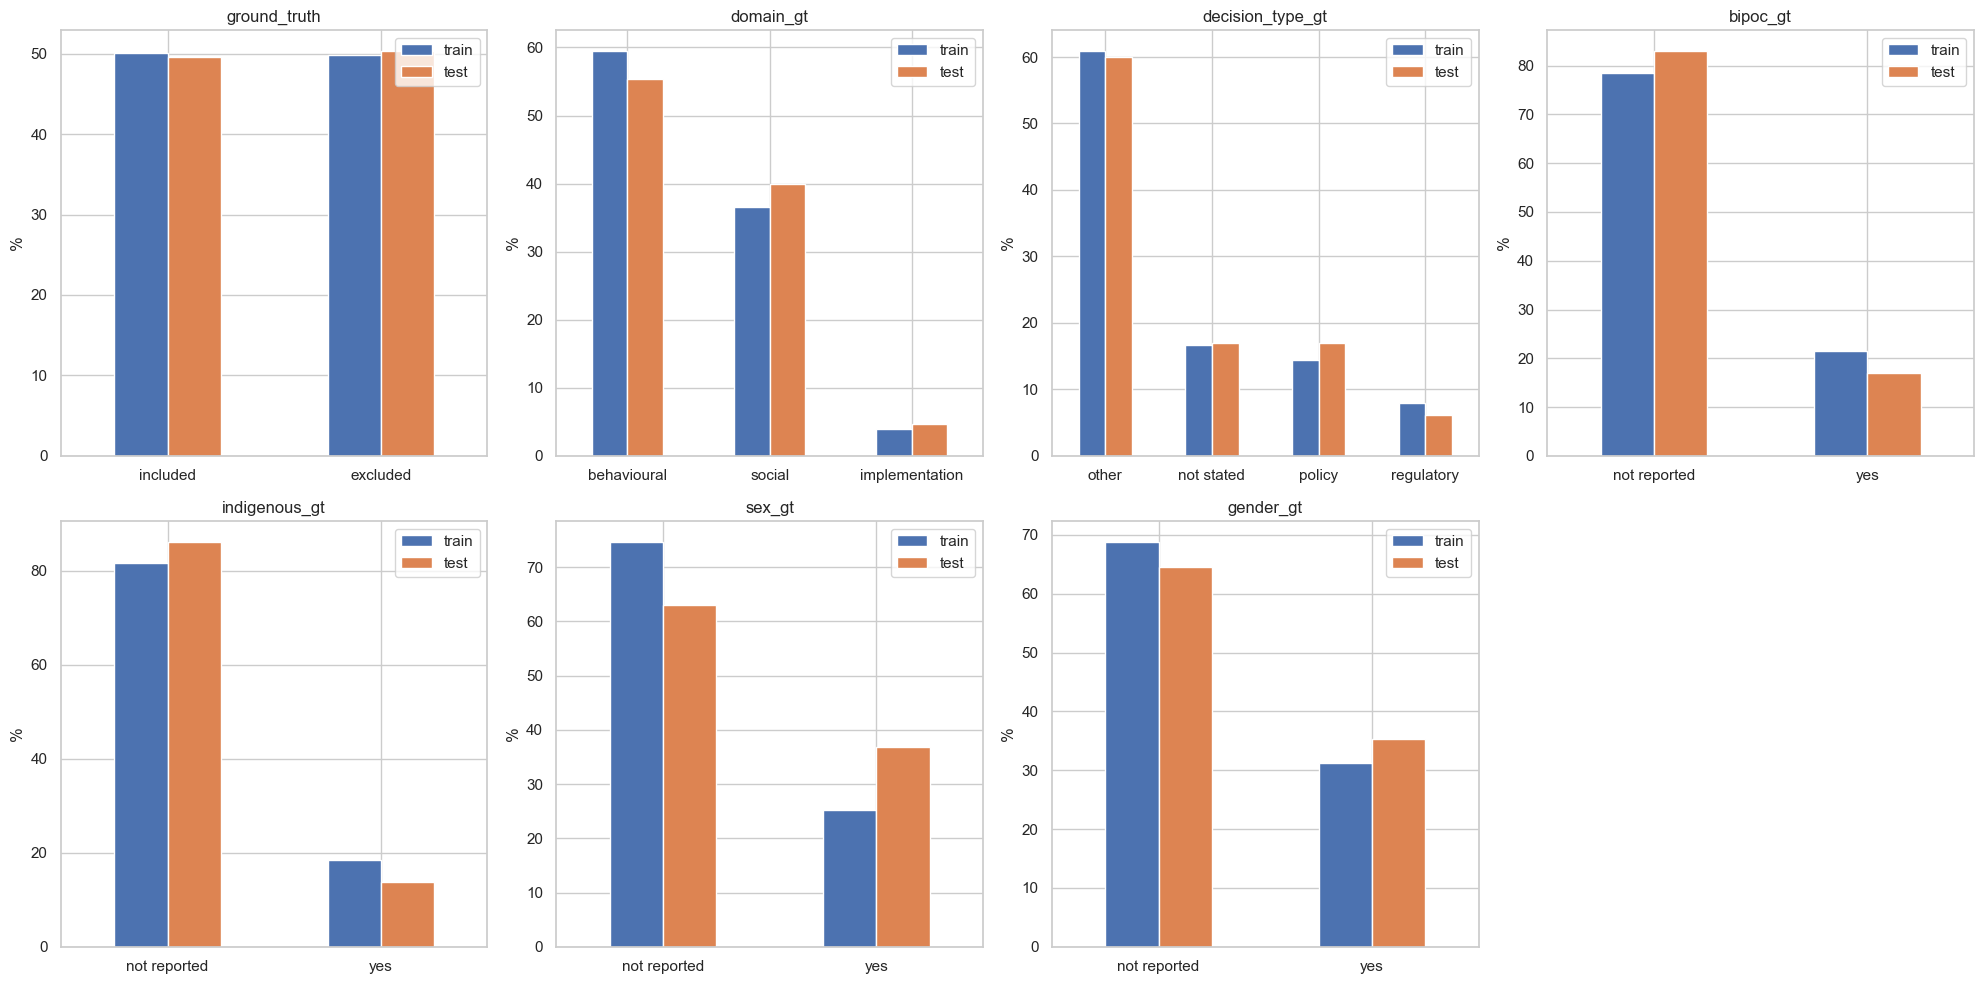

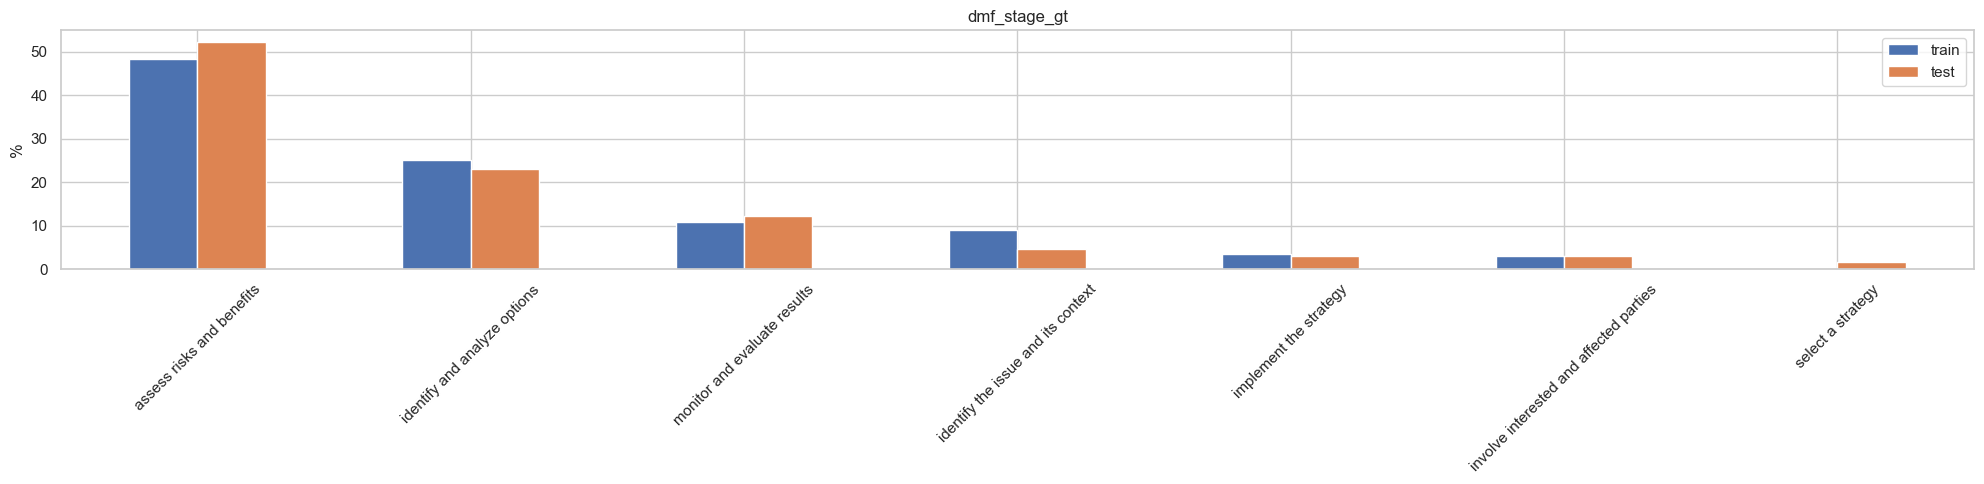

In [18]:
# ╔═══════════════════════════════════════════════════════╗
# ║ Cell 2.8 – Display ground-truth label distribution 🗄️ ║
# ╚═══════════════════════════════════════════════════════╝
import math

cols = ["ground_truth", "domain_gt", "decision_type_gt", "bipoc_gt", "indigenous_gt", "sex_gt", "gender_gt"]
num_fig_cols = math.ceil(len(cols)/2)
fig, ax = plt.subplots(2, num_fig_cols, figsize=(20,10))
for i, col in enumerate(cols):
    counts_train = df_train[col].value_counts(normalize=True) * 100
    counts_test = df_test[col].value_counts(normalize=True) * 100
    df_counts = pd.concat([counts_train, counts_test], axis=1)
    df_counts.columns = ['train', 'test']
    df_counts.rename_axis(None, inplace=True)
    axis = ax[i // num_fig_cols, i % num_fig_cols]
    df_counts.plot(kind='bar', ax=axis, rot=0)
    axis.set_title(col)
    axis.set_ylabel('%')
    axis.legend(loc='upper right')
for j in range(i+1, 2*num_fig_cols):
    fig.delaxes(ax[j // num_fig_cols, j % num_fig_cols])  # remove empty subplots
plt.tight_layout()
plt.show()

col = "dmf_stage_gt"  # plot label distribution separately for "dmf_stage_gt"        
fig2, ax2 = plt.subplots(1, 1, figsize=(20, 5)) 
counts_train = df_train[col].value_counts(normalize=True) * 100
counts_test = df_test[col].value_counts(normalize=True) * 100
df_counts = pd.concat([counts_train, counts_test], axis=1)
df_counts.columns = ['train', 'test']
df_counts.rename_axis(None, inplace=True)
axis = ax2
df_counts.plot(kind='bar', ax=axis, rot=45)
axis.set_title(col)
axis.set_ylabel('%')
axis.legend(loc='upper right')
plt.tight_layout()
plt.show()

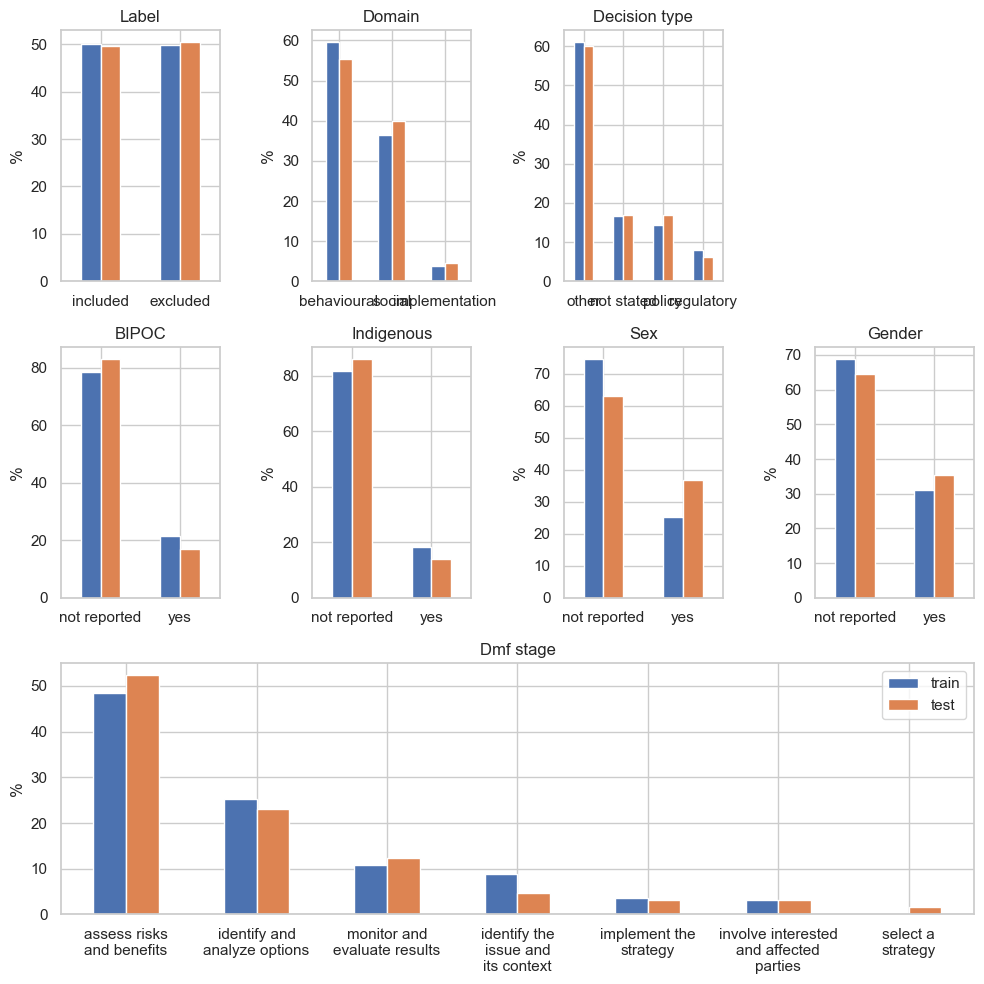

In [71]:
# ╔═════════════════════════════════════════════════════════════════════════════╗
# ║ Cell 2.9 – Create figure for report - Label distributions                   ║
# ╚═════════════════════════════════════════════════════════════════════════════╝

cols = ["ground_truth", "domain_gt", "decision_type_gt", "bipoc_gt", "indigenous_gt", "sex_gt", "gender_gt"]
col_titles = ['Label', 'Domain', 'Decision type', 'BIPOC', 'Indigenous', 'Sex', 'Gender']
num_fig_cols = 4
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(3, 4)

for i, col in enumerate(cols):
    counts_train = df_train[col].value_counts(normalize=True) * 100
    counts_test = df_test[col].value_counts(normalize=True) * 100
    df_counts = pd.concat([counts_train, counts_test], axis=1)
    df_counts.columns = ['train', 'test']
    df_counts.rename_axis(None, inplace=True)
    if i < 3:
        row = 0
        col_idx = i
    else:
        row = 1
        col_idx = i - 3 
    axis = fig.add_subplot(gs[row, col_idx])
    df_counts.plot(kind='bar', ax=axis, rot=0)
    axis.set_title(col_titles[i])
    axis.set_ylabel('%')
    axis.get_legend().set_visible(False)

col = "dmf_stage_gt"      
counts_train = df_train[col].value_counts(normalize=True) * 100
counts_test = df_test[col].value_counts(normalize=True) * 100
df_counts = pd.concat([counts_train, counts_test], axis=1)
df_counts.columns = ['train', 'test']
df_counts.rename_axis(None, inplace=True)
axis = fig.add_subplot(gs[2, :])
df_counts.plot(kind='bar', ax=axis, rot=0)
axis.set_title("Dmf stage")
axis.set_xticklabels([
    "assess risks\nand benefits",
    "identify and\nanalyze options",
    "monitor and\nevaluate results",
    "identify the\nissue and\nits context",
    "implement the\nstrategy",
    "involve interested\nand affected\nparties",
    "select a\nstrategy"
])
axis.set_ylabel('%')
axis.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [19]:
# ╔═════════════════════════════════════════════════════╗
# ║ Cell 3 – Load predictions and merge ground-truth 🗄️ ║
# ╚═════════════════════════════════════════════════════╝
# Structure: {model: {split: DataFrame}}
all_predictions = defaultdict(dict)

for mdir in model_dirs:
    model_name = mdir.name

    for split in ("train", "test"):
        preds_dir = mdir / split / "predictions"
        if not preds_dir.exists():
            continue

        rows = []
        for jf in preds_dir.glob("*.json"):
            with open(jf, encoding="utf-8") as f:
                data = json.load(f)

            pred_block = data.get("prediction", {})
            x = {
                "id": jf.stem,
                "pred_class": pred_block.get("classification"),
                "domain_pred": pred_block.get("domain"),
                "dmf_stage_pred": pred_block.get("dmf_stage"),
                "decision_type_pred": pred_block.get("decision_type"),
                "bipoc_pred": pred_block.get("BIPOC"),
                "indigenous_pred": pred_block.get("Indigenous"),
                "sex_pred": pred_block.get("Sex"),
                "gender_pred": pred_block.get("Gender"),
            }
            rows.append(x)

        if not rows:
            continue

        df_pred = pd.DataFrame(rows)

        # Clean prediction data
        for col in ["pred_class", "domain_pred", "dmf_stage_pred", "decision_type_pred", "bipoc_pred", "indigenous_pred", "sex_pred", "gender_pred"]:
            df_pred[col] = df_pred[col].apply(lambda x: str(x).strip().lower() if x is not None else None)

        if split == "train":
            df_truth = df_train
        else:
            df_truth = df_test

        df = pd.merge(df_pred, df_truth, on="id", how="left")
        all_predictions[model_name][split] = df

        unparsable = (df["pred_class"] == "parseerror").sum()
        print(f"{model_name} [{split}] -> {len(df):,} rows, {unparsable} unparsable")


gpt-4.1 [train] -> 521 rows, 0 unparsable
gpt-4.1 [test] -> 131 rows, 0 unparsable
gpt-4o [train] -> 521 rows, 3 unparsable
gpt-4o [test] -> 131 rows, 2 unparsable
o3 [train] -> 521 rows, 12 unparsable
o3 [test] -> 131 rows, 0 unparsable


In [56]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 4 – Core binary‑classification metrics 📋 ║
# ╚════════════════════════════════════════════════╝
metrics_cls = []

for model, split_dict in all_predictions.items():
    for split, df in split_dict.items():
        parsable = df[df["pred_class"].isin(["included", "excluded"])]
        unparsed = len(df) - len(parsable)
        if parsable.empty:
            continue

        y_true = parsable["ground_truth"]
        y_pred = parsable["pred_class"]

        metrics_cls.append(
            {
                "model": model,
                "split": split,
                "n_total": len(df),
                "n_unparsed": unparsed,
                "accuracy": accuracy_score(y_true, y_pred),
                "precision": precision_score(y_true, y_pred, pos_label="included"),
                "recall": recall_score(y_true, y_pred, pos_label="included"),
                "f1": f1_score(y_true, y_pred, pos_label="included"),
            }
        )

metrics_cls_df = (
    pd.DataFrame(metrics_cls)
    .set_index(["model", "split"])
    .sort_values(["model", "split"])
)
metrics_cls_df.style.format({"accuracy": "{:.3f}", "precision": "{:.3f}", "recall": "{:.3f}", "f1": "{:.3f}"})

C:\Users\MILORTIE\AppData\Local\Temp\ipykernel_22172\2094331698.py:23: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\MILORTIE\Git repositories\padAIwan\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


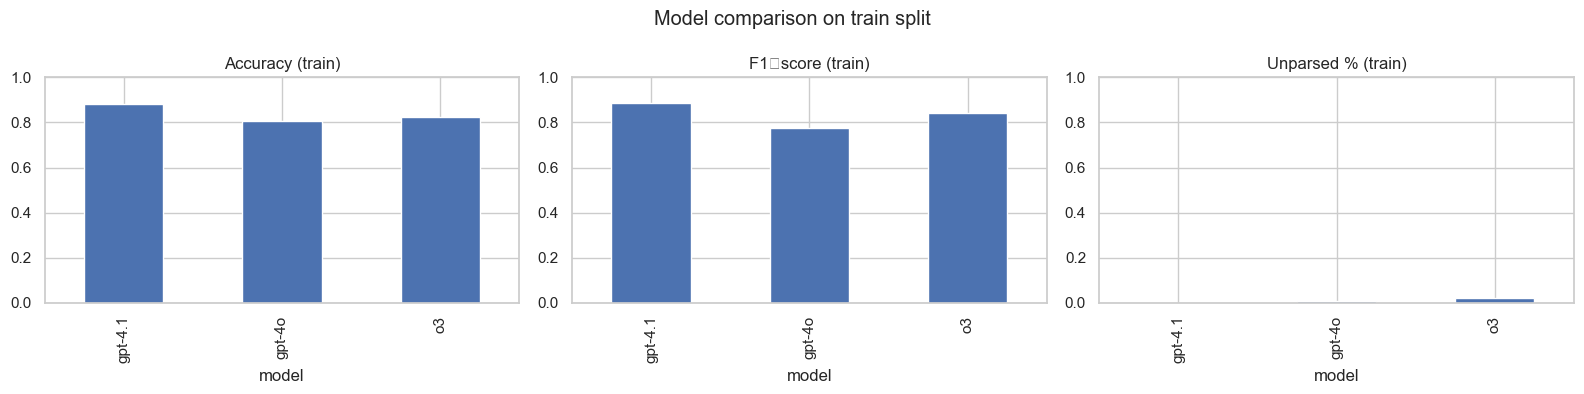

C:\Users\MILORTIE\AppData\Local\Temp\ipykernel_22172\2094331698.py:23: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\MILORTIE\Git repositories\padAIwan\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


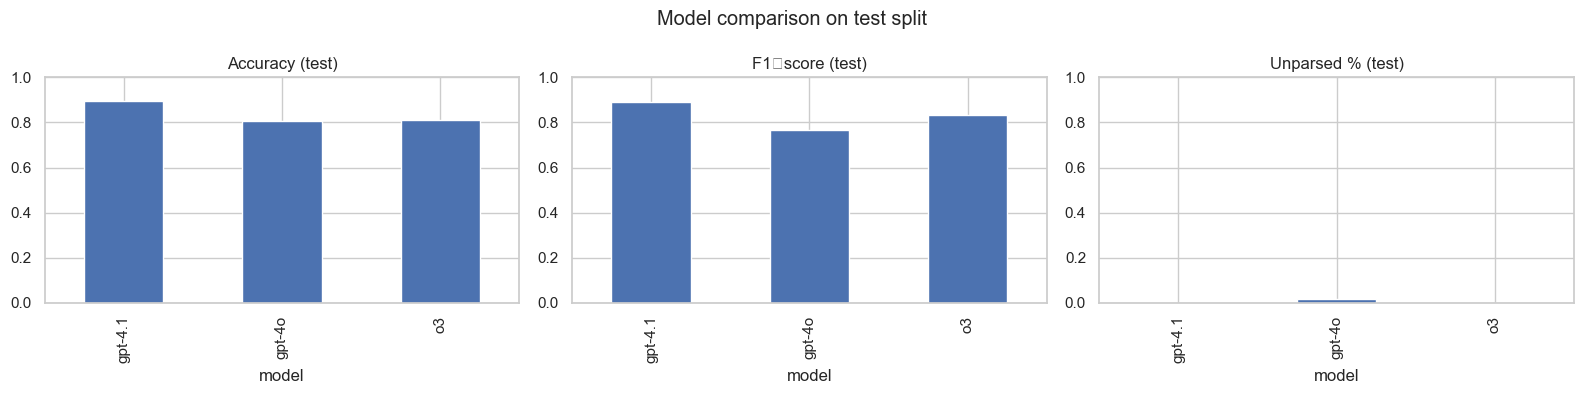

In [57]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 5 – Visualise binary metrics 📊           ║
# ╚════════════════════════════════════════════════╝
for split in ("train", "test"):
    subset = metrics_cls_df.xs(split, level="split")
    if subset.empty:
        continue

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    subset["accuracy"].plot(kind="bar", ax=axes[0])
    axes[0].set_title(f"Accuracy ({split})")
    axes[0].set_ylim(0, 1)

    subset["f1"].plot(kind="bar", ax=axes[1])
    axes[1].set_title(f"F1‑score ({split})")
    axes[1].set_ylim(0, 1)

    (subset["n_unparsed"] / subset["n_total"]).plot(kind="bar", ax=axes[2])
    axes[2].set_title(f"Unparsed % ({split})")
    axes[2].set_ylim(0, 1)

    plt.suptitle(f"Model comparison on {split} split")
    plt.tight_layout()
    plt.show()

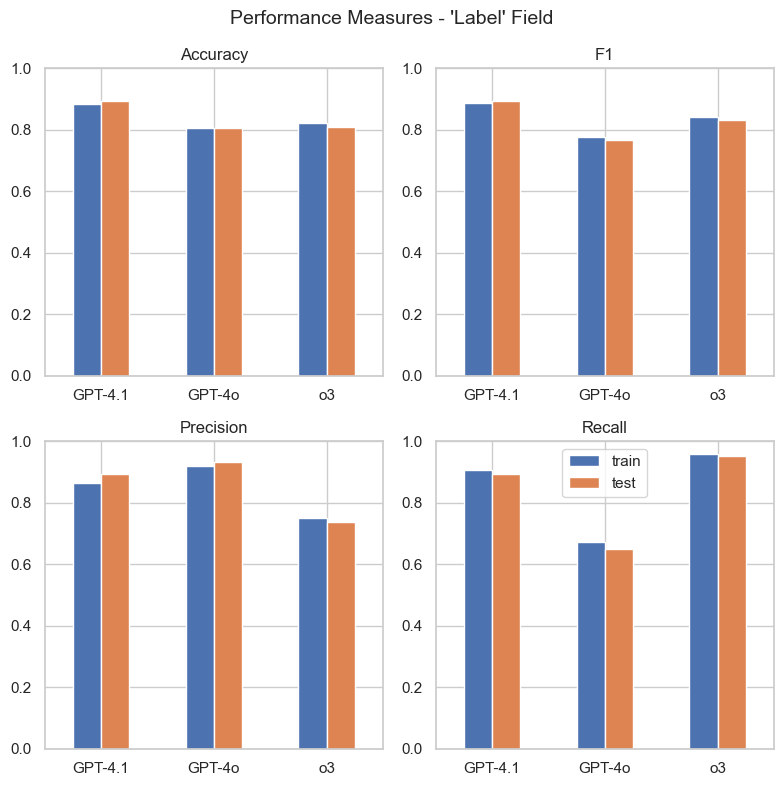

In [61]:
# ╔═════════════════════════════════════════════════════════════════════════════╗
# ║ Cell 5.5 – Create figure for report - Performance measures - 'Label' field  ║
# ╚═════════════════════════════════════════════════════════════════════════════╝

if not isinstance(metrics_cls_df.index, pd.RangeIndex):
    metrics_cls_df = metrics_cls_df.reset_index()
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
i = 0
for col in ["accuracy", "f1", "precision", "recall"]:
    metrics_cls_pivot = (
        metrics_cls_df
        .pivot(index="model", columns="split", values=col)
        .reindex(["gpt-4.1", "gpt-4o", "o3"])
        .reindex(columns=["train", "test"])
    )
    axis = axes[i]
    metrics_cls_pivot.plot(kind="bar", ax=axis, rot=0)
    axis.set_title(f"{col.capitalize()}")
    axis.set_xlabel("")
    axis.set_xticklabels(['GPT-4.1', 'GPT-4o', 'o3'])
    axis.set_ylim(0, 1)
    if col == "recall":
        axis.legend(title="")
    else:
        axis.get_legend().set_visible(False) 
    i += 1

fig.suptitle("Performance Measures - 'Label' Field", fontsize=14)
plt.tight_layout()
plt.show()

In [22]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 6 – Extra-field scoring 🏷️               ║
# ╚════════════════════════════════════════════════╝
extra_metrics = []
fields = [
    ("domain_pred",       "domain_gt",       "domain"),
    ("dmf_stage_pred",    "dmf_stage_gt",    "dmf_stage"),
    ("decision_type_pred","decision_type_gt","decision_type"),
    ("bipoc_pred",        "bipoc_gt",        "bipoc"),
    ("indigenous_pred",   "indigenous_gt",   "indigenous"),
    ("sex_pred",          "sex_gt",          "sex"),
    ("gender_pred",       "gender_gt",       "gender")
]

for model, split_dict in all_predictions.items():
    for split, df in split_dict.items():

        # evaluate only items predicted as "included"  
        include_rows = df["pred_class"] == "included"

        # do not evaluate items for which ground truth label is 'included' but other ground truth fields are None
        if fields:
            conditions = [df["ground_truth"] == "included"]
            for field in fields:
                conditions.append(df[field[1]].isna())
            exclude_rows = pd.concat(conditions, axis=1).all(axis=1)
            df_inc = df[include_rows & ~exclude_rows].copy()
        else:
            df_inc = df[include_rows].copy()

        if df_inc.empty:
            continue

        for pcol, tcol, name in fields:
            
            # exclude rows where ground_truth label is "included" and value in tcol equals None
            excl = (df_inc["ground_truth"] == "included") & df_inc[tcol].isna()

            if (~excl).sum() > 0:
                acc = accuracy_score(df_inc.loc[~excl, tcol].fillna(''), df_inc.loc[~excl, pcol].fillna(''))
                cl = df_inc.loc[~excl, tcol].fillna('').unique()
                class_labels = [x for x in cl if x]  # remove empty string from class labels                        
                f1 = f1_score(df_inc.loc[~excl, tcol].fillna(''), df_inc.loc[~excl, pcol].fillna(''), average='macro', labels=class_labels)
                #f1_weighted = f1_score(df_inc.loc[~excl, tcol].fillna(''), df_inc.loc[~excl, pcol].fillna(''), average='weighted', labels=class_labels)
                #f1_none = f1_score(df_inc.loc[~excl, tcol].fillna(''), df_inc.loc[~excl, pcol].fillna(''), average=None, labels=class_labels)
                #print(f"{model} {split} {name} f1_macro: {f1:.3f} f1_weighted: {f1_weighted:.3f}")
                #print(f"{class_labels} : {f1_none}")                
            else:
                acc = float("nan")
                f1 = float("nan")

            extra_metrics.append(
                {
                    "model"   : model,
                    "split"   : split,
                    "field"   : name,
                    "n_scored": (~excl).sum(),
                    "accuracy": round(acc, 3),
                    "f1"      : round(f1, 3),
                }
            )

# ---- pivot & pretty-print ---- #
a_extra = pd.DataFrame(extra_metrics)
if not a_extra.empty:
    pivot_acc = a_extra.pivot(index=["model", "split"], columns="field", values="accuracy")
    pivot_acc = pivot_acc[["domain", "dmf_stage", "decision_type", "bipoc", "indigenous", "sex", "gender"]]
    print('Accuracy:')
    display(pivot_acc.style.format("{:.3f}"))
    pivot_f1 = a_extra.pivot(index=["model", "split"], columns="field", values="f1")
    pivot_f1 = pivot_f1[["domain", "dmf_stage", "decision_type", "bipoc", "indigenous", "sex", "gender"]]
    print('F1‑score:')
    display(pivot_f1.style.format("{:.3f}"))
else:
    print("Cannot score extra fields.")

Accuracy:


F1‑score:


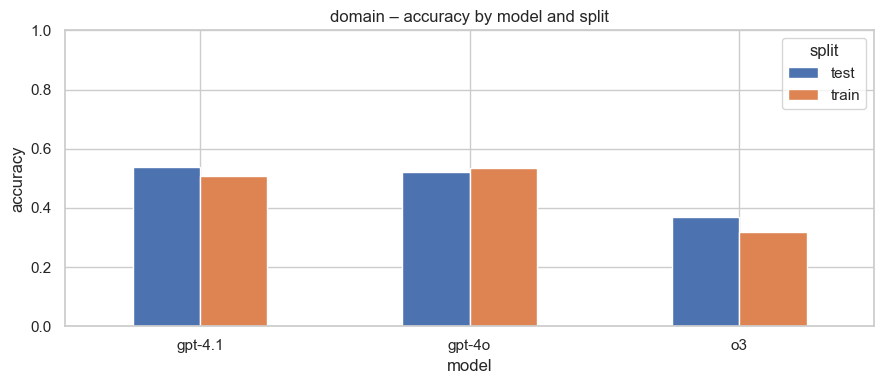

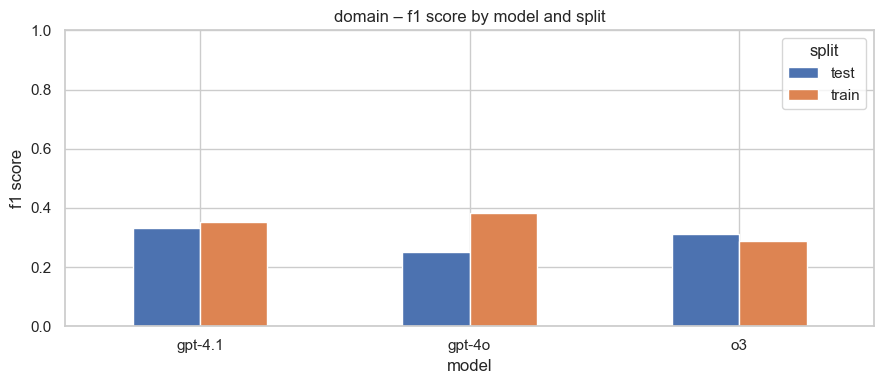

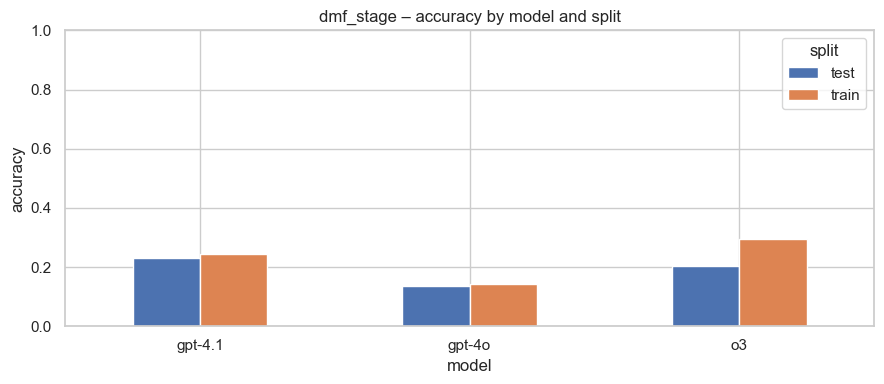

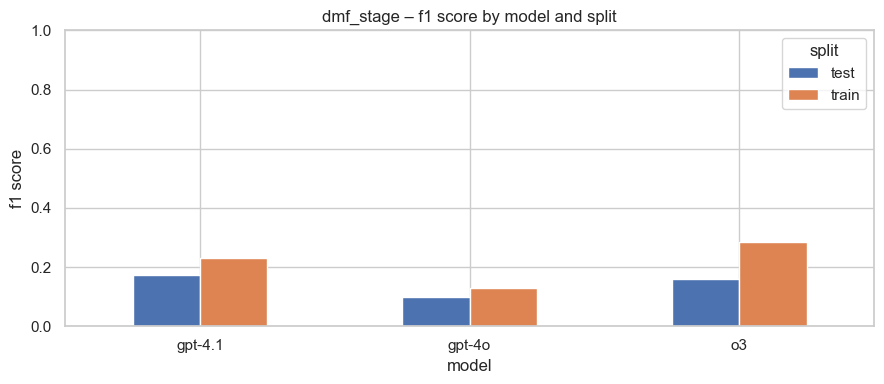

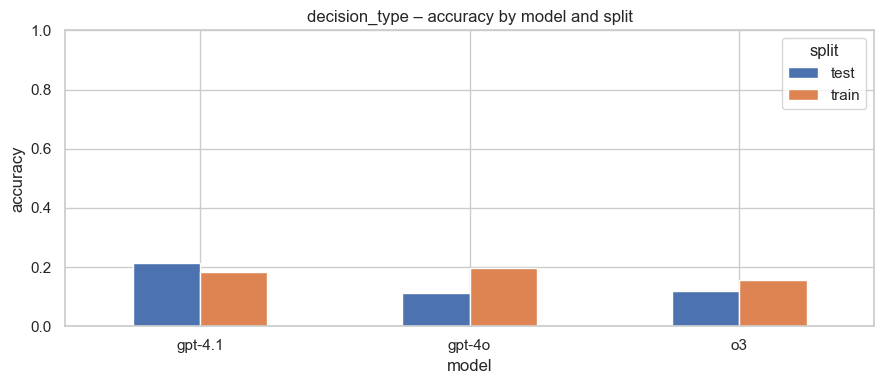

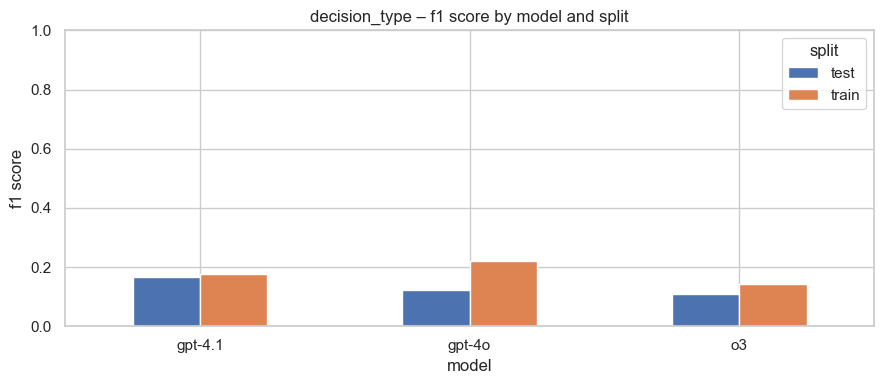

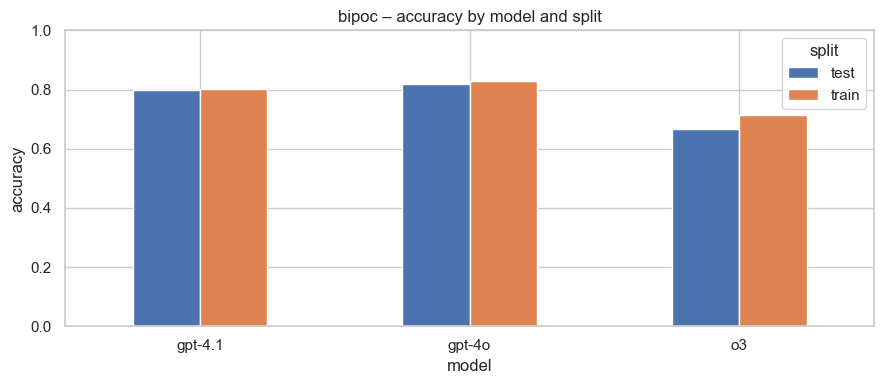

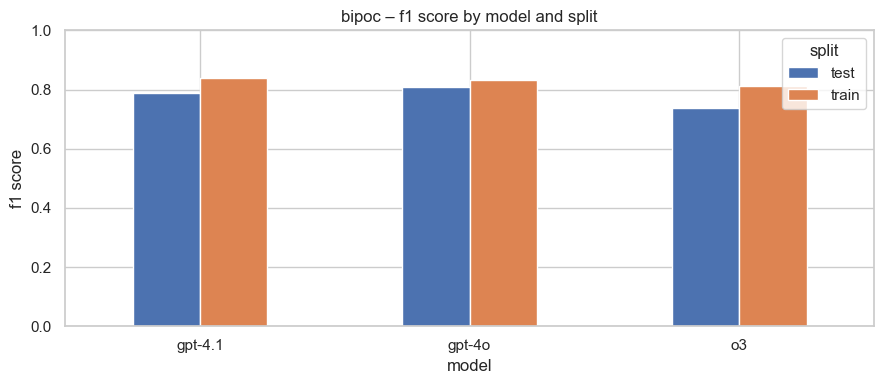

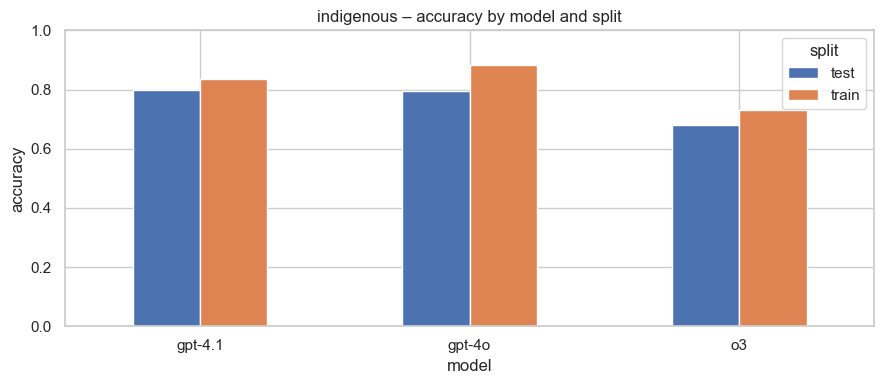

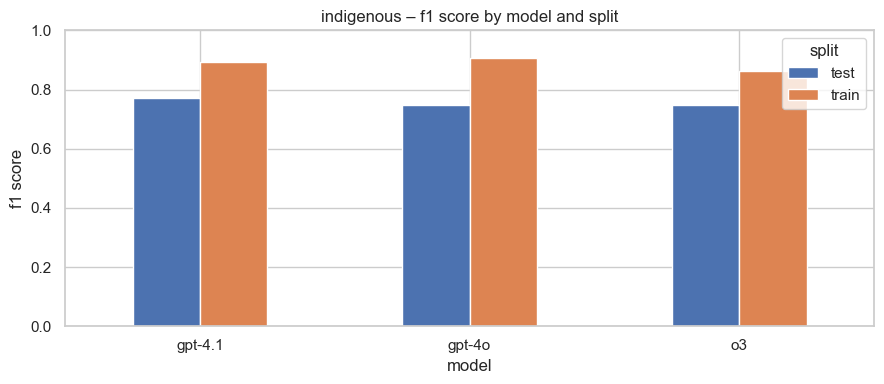

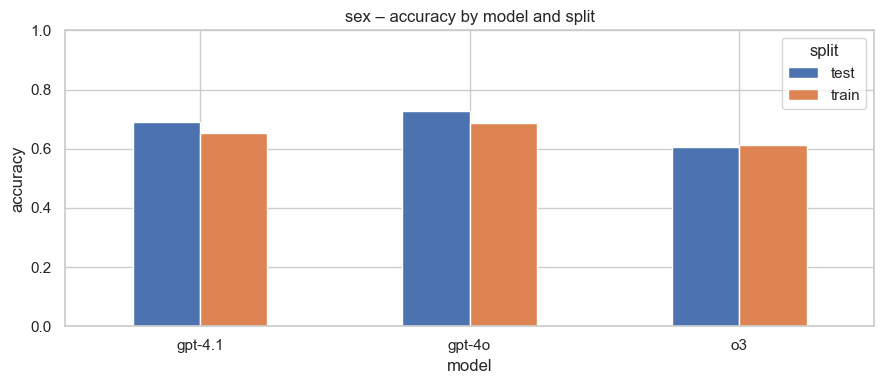

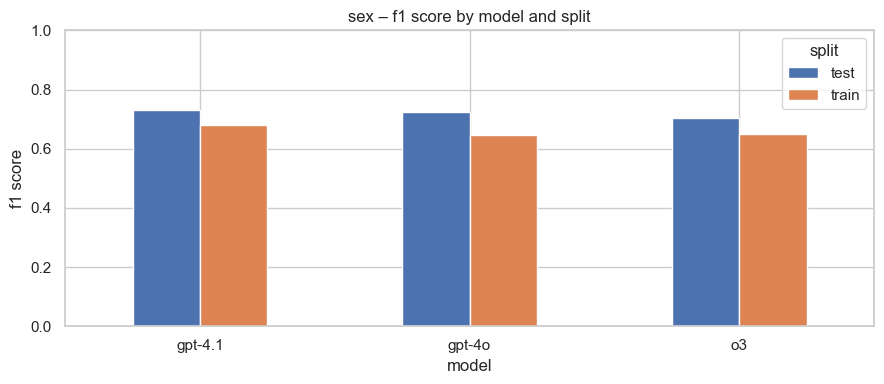

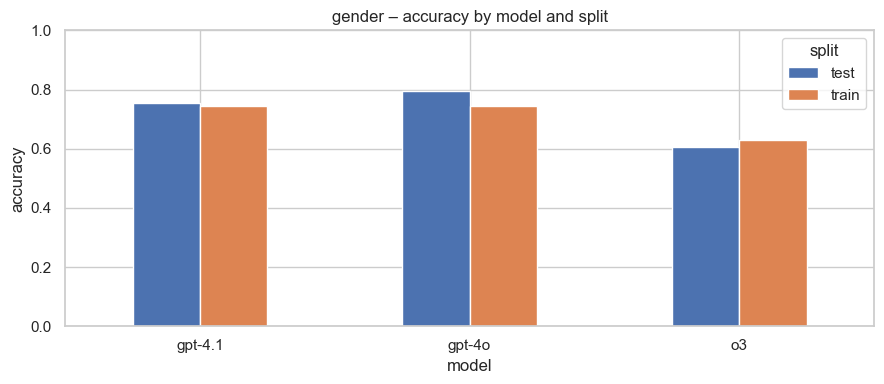

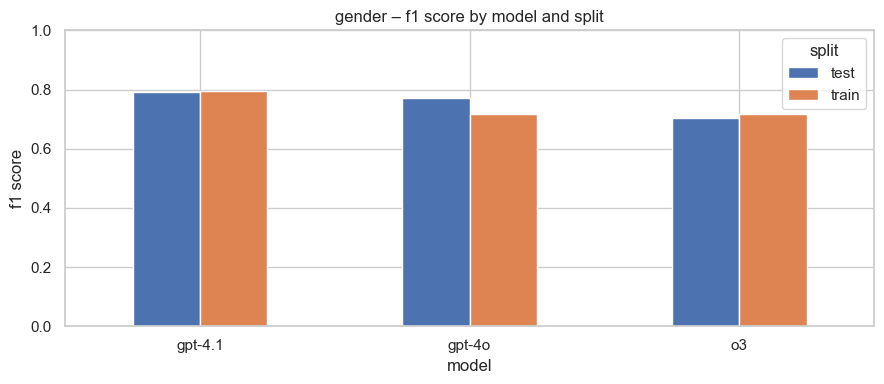

In [23]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ Cell 7 – Visualise extra-field accuracy and f1 score 📊🏷️   ║
# ╚══════════════════════════════════════════════════════════════╝
if not a_extra.empty:
    for field in ["domain", "dmf_stage", "decision_type", "bipoc", "indigenous", "sex", "gender"]:
        fig, ax = plt.subplots(figsize=(9, 4))
        subset_acc = a_extra[a_extra["field"] == field].pivot(
            index="model", columns="split", values="accuracy"
        )
        subset_acc.plot(kind="bar", ax=ax, rot=0)  # one bar-group per model
        ax.set_title(f"{field} – accuracy by model and split")
        ax.set_ylabel("accuracy")
        ax.set_xlabel("model")
        ax.set_ylim(0, 1)
        ax.legend(title="split")
        plt.tight_layout()
        plt.show()

        fig2, ax2 = plt.subplots(figsize=(9, 4))
        subset_f1 = a_extra[a_extra["field"] == field].pivot(
            index="model", columns="split", values="f1"
        )
        subset_f1.plot(kind="bar", ax=ax2, rot=0)  # one bar-group per model
        ax2.set_title(f"{field} – f1 score by model and split")
        ax2.set_ylabel("f1 score")
        ax2.set_xlabel("model")
        ax2.set_ylim(0, 1)
        ax2.legend(title="split")
        plt.tight_layout()
        plt.show()
else:
    print("No extra-field metrics to plot.")


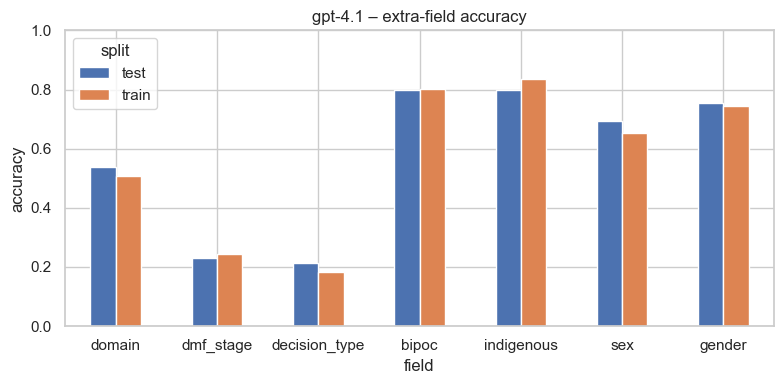

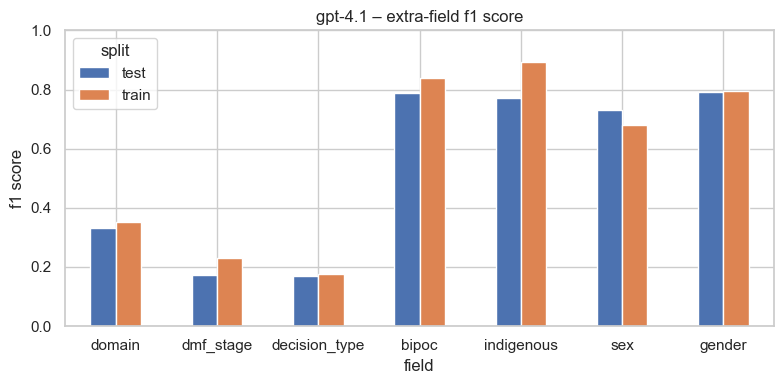

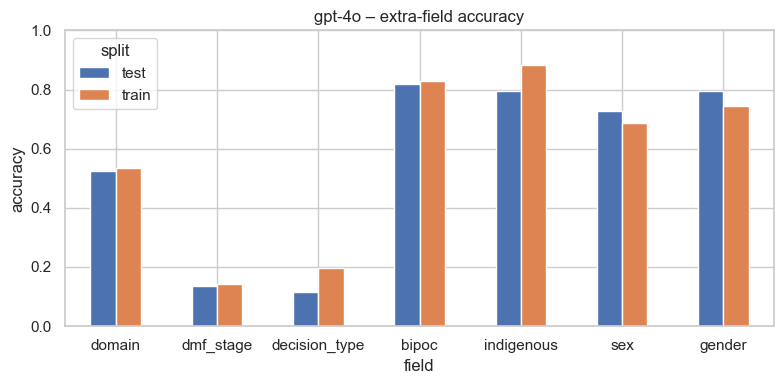

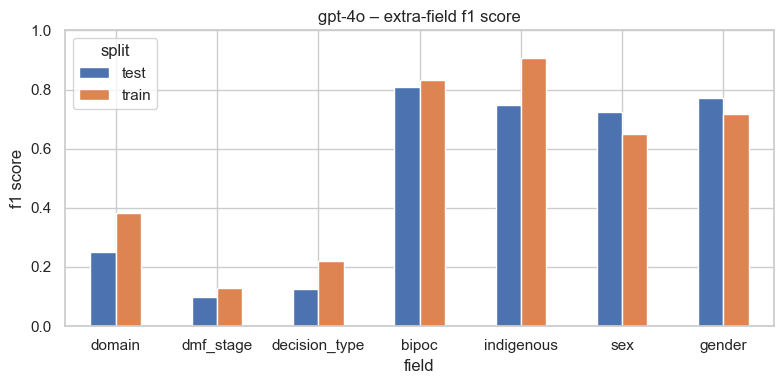

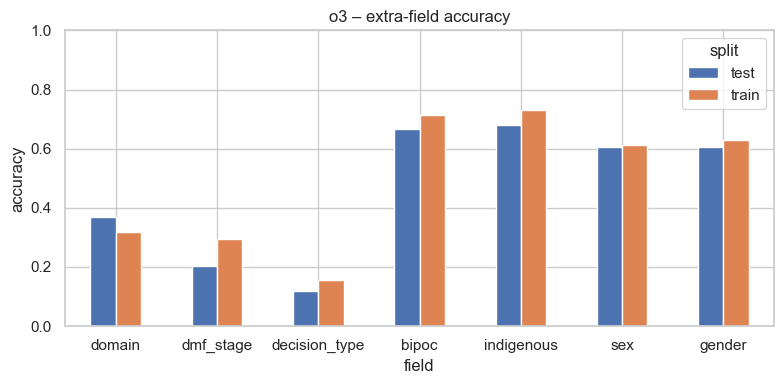

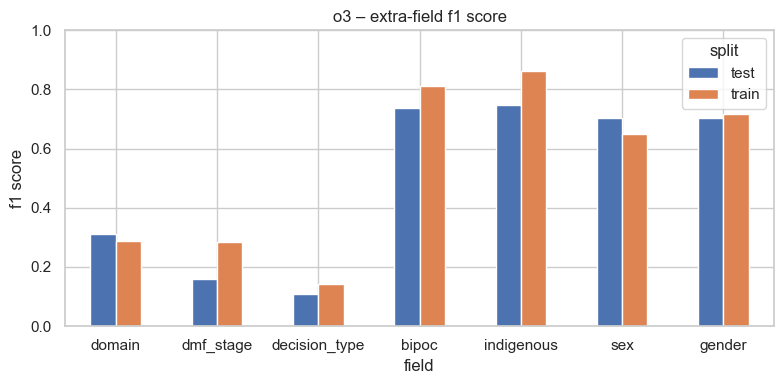

In [24]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ Cell 8 – Per-model feature accuracy and f1 score 📊         ║
# ╚═════════════════════════════════════════════════════════════╝
if not a_extra.empty:
    for model_name in a_extra["model"].unique():
        fig, ax = plt.subplots(figsize=(8, 4))
        subset_acc = (
            a_extra[a_extra["model"] == model_name]
            .pivot(index="field", columns="split", values="accuracy")
            .reindex(["domain", "dmf_stage", "decision_type", "bipoc", "indigenous", "sex", "gender"])
        )
        subset_acc.plot(kind="bar", ax=ax, rot=0)
        ax.set_title(f"{model_name} – extra-field accuracy")
        ax.set_ylabel("accuracy")
        ax.set_xlabel("field")
        ax.set_ylim(0, 1)
        ax.legend(title="split")
        plt.tight_layout()
        plt.show()

        fig2, ax2 = plt.subplots(figsize=(8, 4))
        subset_f1 = (
            a_extra[a_extra["model"] == model_name]
            .pivot(index="field", columns="split", values="f1")
            .reindex(["domain", "dmf_stage", "decision_type", "bipoc", "indigenous", "sex", "gender"])
        )
        subset_f1.plot(kind="bar", ax=ax2, rot=0)
        ax2.set_title(f"{model_name} – extra-field f1 score")
        ax2.set_ylabel("f1 score")
        ax2.set_xlabel("field")
        ax2.set_ylim(0, 1)
        ax2.legend(title="split")
        plt.tight_layout()
        plt.show()
else:
    print("No extra-field metrics to plot.")

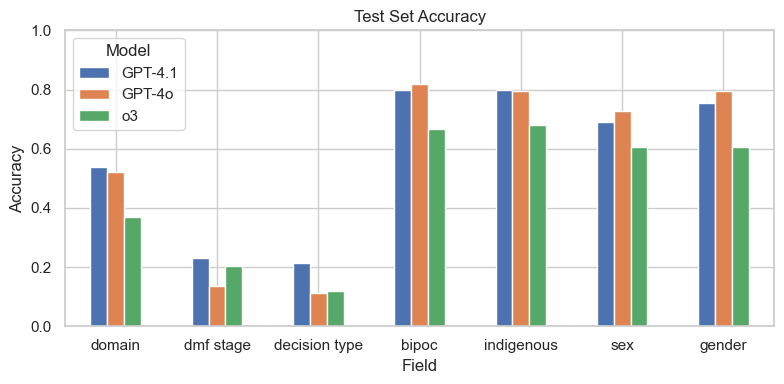

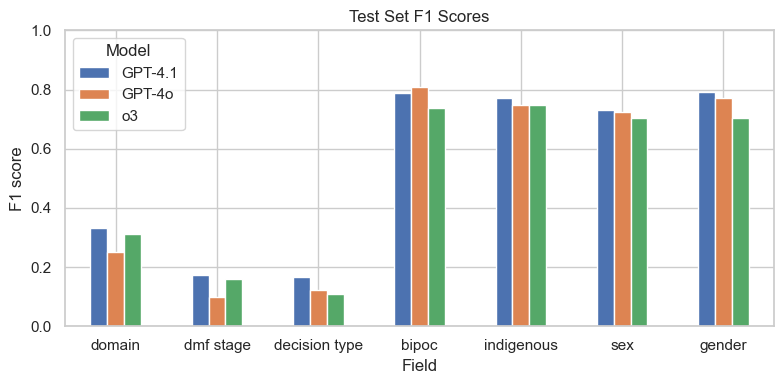

In [33]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║ Cell 8.5 – Create figure for report - extra field performance measures 🔲 ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

if not a_extra.empty:
    fig, ax = plt.subplots(figsize=(8, 4))
    subset_acc = (
        a_extra[a_extra["split"] == 'test']
        .pivot(index="field", columns="model", values="accuracy")
        .reindex(["domain", "dmf_stage", "decision_type", "bipoc", "indigenous", "sex", "gender"])
    )
    subset_acc.plot(kind="bar", ax=ax, rot=0)
    ax.set_title(f"Test Set Accuracy")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Field")
    ax.set_ylim(0, 1)
    ax.set_xticklabels(["domain", "dmf stage", "decision type", "bipoc", "indigenous", "sex", "gender"])
    ax.legend(["GPT-4.1", "GPT-4o", "o3"], title="Model")
    plt.tight_layout()
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(8, 4))
    subset_f1 = (
        a_extra[a_extra["split"] == "test"]
        .pivot(index="field", columns="model", values="f1")
        .reindex(["domain", "dmf_stage", "decision_type", "bipoc", "indigenous", "sex", "gender"])
    )
    subset_f1.plot(kind="bar", ax=ax2, rot=0)
    ax2.set_title(f"Test Set F1 Scores")
    ax2.set_ylabel("F1 score")
    ax2.set_xlabel("Field")
    ax2.set_ylim(0, 1)
    ax2.set_xticklabels(["domain", "dmf stage", "decision type", "bipoc", "indigenous", "sex", "gender"])
    ax2.legend(["GPT-4.1", "GPT-4o", "o3"], title="Model")
    plt.tight_layout()
    plt.show()
else:
    print("No extra-field metrics to plot.")


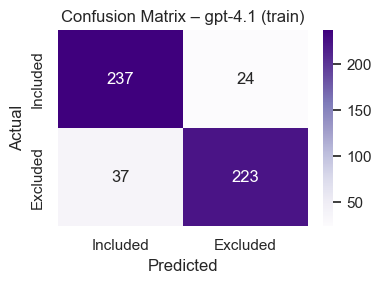

Classification report for gpt-4.1 (train)
              precision    recall  f1-score   support

    excluded      0.903     0.858     0.880       260
    included      0.865     0.908     0.886       261

    accuracy                          0.883       521
   macro avg      0.884     0.883     0.883       521
weighted avg      0.884     0.883     0.883       521



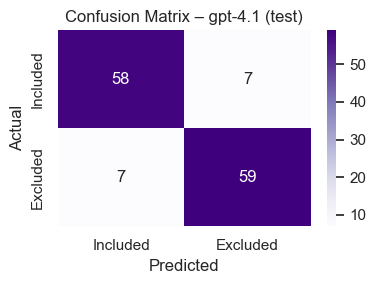

Classification report for gpt-4.1 (test)
              precision    recall  f1-score   support

    excluded      0.894     0.894     0.894        66
    included      0.892     0.892     0.892        65

    accuracy                          0.893       131
   macro avg      0.893     0.893     0.893       131
weighted avg      0.893     0.893     0.893       131



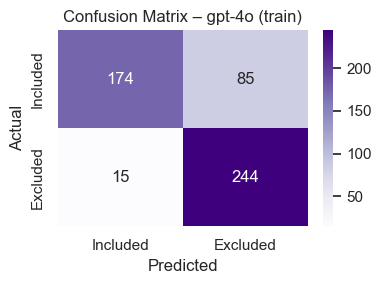

Classification report for gpt-4o (train)
              precision    recall  f1-score   support

    excluded      0.742     0.942     0.830       259
    included      0.921     0.672     0.777       259

    accuracy                          0.807       518
   macro avg      0.831     0.807     0.803       518
weighted avg      0.831     0.807     0.803       518



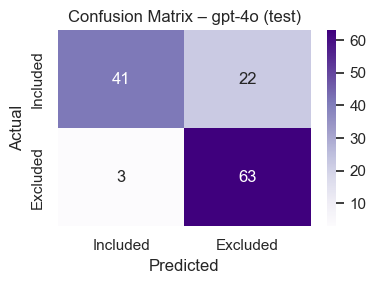

Classification report for gpt-4o (test)
              precision    recall  f1-score   support

    excluded      0.741     0.955     0.834        66
    included      0.932     0.651     0.766        63

    accuracy                          0.806       129
   macro avg      0.836     0.803     0.800       129
weighted avg      0.834     0.806     0.801       129



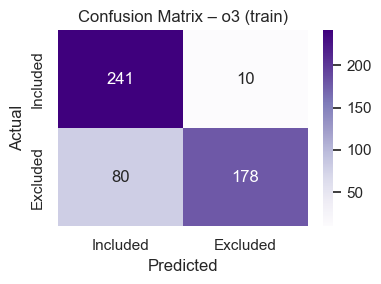

Classification report for o3 (train)
              precision    recall  f1-score   support

    excluded      0.947     0.690     0.798       258
    included      0.751     0.960     0.843       251

    accuracy                          0.823       509
   macro avg      0.849     0.825     0.820       509
weighted avg      0.850     0.823     0.820       509



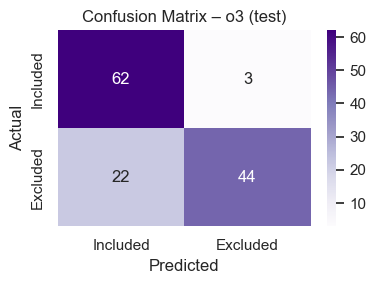

Classification report for o3 (test)
              precision    recall  f1-score   support

    excluded      0.936     0.667     0.779        66
    included      0.738     0.954     0.832        65

    accuracy                          0.809       131
   macro avg      0.837     0.810     0.805       131
weighted avg      0.838     0.809     0.805       131



In [25]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 9 – Confusion matrices for binary task 🔲 ║
# ╚════════════════════════════════════════════════╝
for model, split_dict in all_predictions.items():
    for split, df in split_dict.items():
        parsable = df[df["pred_class"].isin(["included", "excluded"])]
        if parsable.empty:
            continue

        y_true = parsable["ground_truth"]
        y_pred = parsable["pred_class"]

        cm = confusion_matrix(y_true, y_pred, labels=["included", "excluded"])
        plt.figure(figsize=(4, 3))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Purples",
            xticklabels=["Included", "Excluded"],
            yticklabels=["Included", "Excluded"],
        )
        plt.title(f"Confusion Matrix – {model} ({split})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

        print(f"Classification report for {model} ({split})")
        print(classification_report(y_true, y_pred, digits=3))

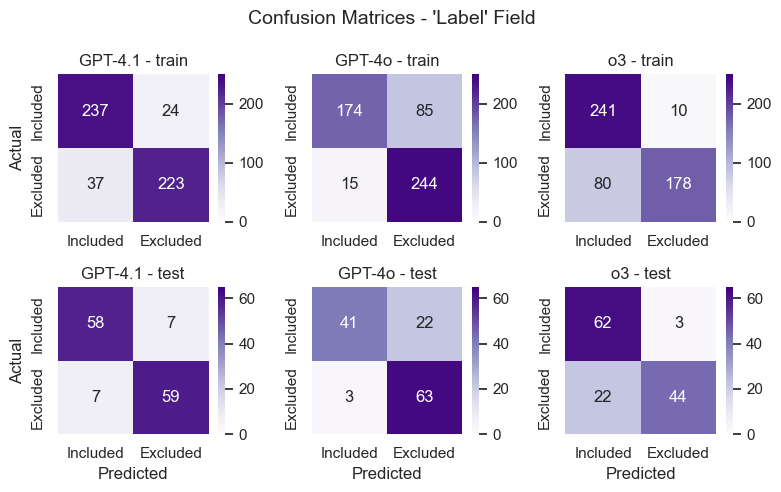

In [49]:
# ╔═══════════════════════════════════════════════════════════════════════════════════════╗
# ║ Cell 9.5 – Create figure for report - confusion matrices for include/exclude field 🔲 ║
# ╚═══════════════════════════════════════════════════════════════════════════════════════╝

fig, ax = plt.subplots(2, 3, figsize=(8, 5))
row = 0
col = 0
for model, split_dict in all_predictions.items():
    for split, df in split_dict.items():
        parsable = df[df["pred_class"].isin(["included", "excluded"])]
        if parsable.empty:
            continue

        y_true = parsable["ground_truth"]
        y_pred = parsable["pred_class"]

        cm = confusion_matrix(y_true, y_pred, labels=["included", "excluded"])
        axis = ax[row, col]
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Purples",
            xticklabels=["Included", "Excluded"],
            yticklabels=["Included", "Excluded"],
            ax=axis,
            vmin=0,
            vmax=250 if split == "train" else 65,
        )
        
        if model == 'gpt-4.1':
            axis.set_title(f"GPT-4.1 - {split}")
        elif model == 'gpt-4o':
            axis.set_title(f"GPT-4o - {split}")
        else:
            axis.set_title(f"o3 - {split}")

        if row == 1:
            axis.set_xlabel("Predicted")
        if col == 0:
            axis.set_ylabel("Actual")

        row += 1
    col += 1   
    row = 0 
fig.suptitle("Confusion Matrices - 'Label' Field", fontsize=14)
plt.tight_layout()
plt.show()

In [26]:
# ╔═════════════════════════════════════════════════════════════════╗
# ║ Cell 10 - Free‑text field evaluation summary from XLSX results ║
# ╚═════════════════════════════════════════════════════════════════╝

# Note: This evaluation occurs after binary classification is complete. The results are only represent performance on true positives (include/exclude column).

outputs_root = Path.cwd() / "outputs"
ft_metrics = []

for model_dir in outputs_root.iterdir():
    if not model_dir.is_dir():
        continue
    model = model_dir.name
    for split in ("train", "test"):
        file_path = model_dir / split / f"free_text_eval_{model}_{split}.xlsx"
        if file_path.exists():
            df = pd.read_excel(file_path)
            df["model"] = model
            df["split"] = split
            ft_metrics.append(df)
        else:
            print(f"Warning: Missing file {file_path}")

if ft_metrics:
    df_ft = pd.concat(ft_metrics, ignore_index=True)
    summary = (
        df_ft
        .melt(
            id_vars=["model","split","id"],
            value_vars=["audience_correct","methodology_correct","sample_size_correct","identity_factors_correct"],
            var_name="field",
            value_name="correct"
        )
        .groupby(["model","split","field"])
        .agg(n_scored=("correct","size"), accuracy=("correct","mean"))
        .reset_index()
    )
    display(
        summary
        .pivot(index=["model","split"], columns="field", values="accuracy")
        .style.format("{:.3f}")
    )
else:
    print("No evaluation xlsx files found. Run free-text inferences first.")

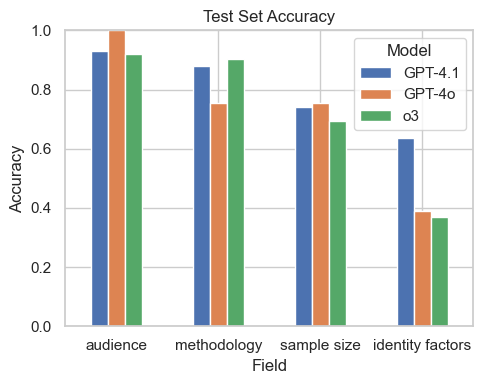

In [37]:
# ╔═══════════════════════════════════════════════════════════════════════════╗
# ║ Cell 10.5 – Create figure for report - free-text field performance measures 🔲 ║
# ╚═══════════════════════════════════════════════════════════════════════════╝

if not summary.empty:
    fig, ax = plt.subplots(figsize=(5, 4))
    subset = (
        summary[summary["split"] == 'test']
        .pivot(index="field", columns="model", values="accuracy")
        .reindex(["audience_correct", "methodology_correct", "sample_size_correct", "identity_factors_correct"])
    )
    subset.plot(kind="bar", ax=ax, rot=0)
    ax.set_title("Test Set Accuracy")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Field")
    ax.set_ylim(0, 1)
    ax.set_xticklabels(["audience", "methodology", "sample size", "identity factors"])
    ax.legend(["GPT-4.1", "GPT-4o", "o3"], title="Model")
    plt.tight_layout()
    plt.show()
else:
    print("No extra-field metrics to plot.")